In [5]:
import pandas as pd
import scanpy as sc

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import scanpy as sc
import anndata as ad 
import scanpy.external as sce

In [7]:
counts_path = "GSE180878_Li_Brugge_10XscRNAseq_GeneCellMatrix_RNAcounts_human.csv.gz"
metadata_path = "GSE180878_Li_Brugge_10XscRNAseq_Metadata_human.csv"

adata = sc.read_csv(counts_path, delimiter=',').transpose()
metadata = pd.read_csv(metadata_path)

print(adata)

FileNotFoundError: [Errno 2] No such file or directory: 'GSE180878_Li_Brugge_10XscRNAseq_GeneCellMatrix_RNAcounts_human.csv.gz'

In [ ]:
metadata.set_index("cellID", inplace=True)

In [ ]:
adata.obs = adata.obs.join(metadata, how="left")

In [ ]:
metadata["Cell.subtype"].value_counts()

Cell.subtype
HSb              10354
AP               10025
VL2_VE            6322
F3                6047
BL                5701
BAb               2622
HSa               2422
VL3_PE            2110
F2                1704
I3_Tcell          1611
HS_doublets       1193
I1_Myeloid         659
BAa                515
F_doublets         443
F1                 269
I5_PlasmaCell      206
VL1_LE             178
I2_NK              120
BA_doublets        115
I4_Bcell            65
Name: count, dtype: int64

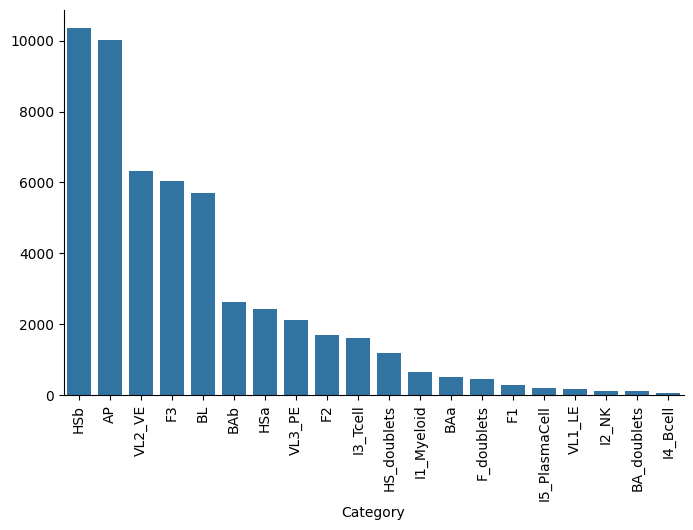

In [ ]:
# Create the bar plot
plt.figure(figsize=(8, 5))
sns.barplot(x=metadata["Cell.subtype"].value_counts().index, 
            y=metadata["Cell.subtype"].value_counts().values)

# Customize the plot
plt.xlabel("Category")
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
sns.despine()  # Remove top and right spines

# Show the plot
plt.show()

In [ ]:
adata.obs["type"] = metadata["Cell.subtype"]

In [ ]:
adata.obs["type"].value_counts()

type
HSb              10354
AP               10025
VL2_VE            6322
F3                6047
BL                5701
BAb               2622
HSa               2422
VL3_PE            2110
F2                1704
I3_Tcell          1611
HS_doublets       1193
I1_Myeloid         659
BAa                515
F_doublets         443
F1                 269
I5_PlasmaCell      206
VL1_LE             178
I2_NK              120
BA_doublets        115
I4_Bcell            65
Name: count, dtype: int64

In [ ]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")


In [ ]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

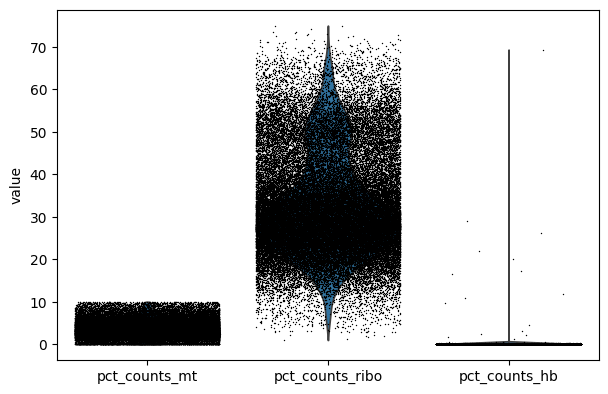

In [ ]:
sc.pl.violin(
    adata,
    ["pct_counts_mt", "pct_counts_ribo", "pct_counts_hb"],
    jitter=0.4,
    multi_panel=False,
)

In [ ]:
# Set QC thresholds
mt_threshold = 10  # Percentage of mitochondrial counts
ribo_threshold = 60  # Percentage of ribosomal counts
hb_threshold = 60 # Percentage of hemoglobin counts

# Apply QC filters
filter_condition = (
        (adata.obs["pct_counts_mt"] < mt_threshold) & 
        (adata.obs["pct_counts_ribo"] < ribo_threshold) &
        (adata.obs["pct_counts_hb"] < hb_threshold)
)

adata = adata[filter_condition]

In [ ]:
adata.obs["surgery"] = adata.obs.index.str[:2]

C:\Users\Marcos\AppData\Local\Temp\ipykernel_18092\825043132.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["surgery"] = adata.obs.index.str[:2]


In [ ]:
adata.obs["surgery"].value_counts()

surgery
PM    32502
RM    18971
Name: count, dtype: int64

In [ ]:
# Saving count data
adata.layers["counts"] = adata.X.copy()

sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)

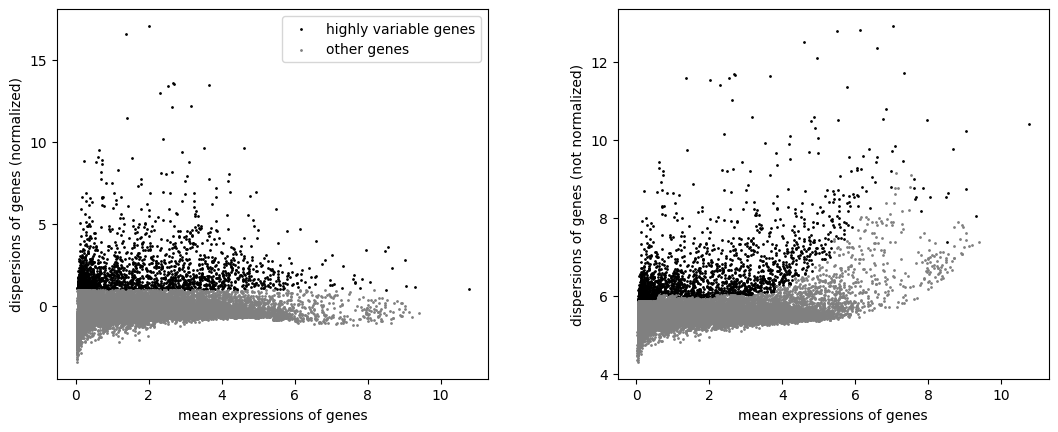

In [ ]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
sc.pl.highly_variable_genes(adata)

In [ ]:
adata_hvg = adata[:, adata.var['highly_variable']]

c:\Users\Marcos\anaconda3\envs\conformals\lib\site-packages\scanpy\tools\_utils.py:41: UserWarning: You’re trying to run this on 2000 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(
c:\Users\Marcos\anaconda3\envs\conformals\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


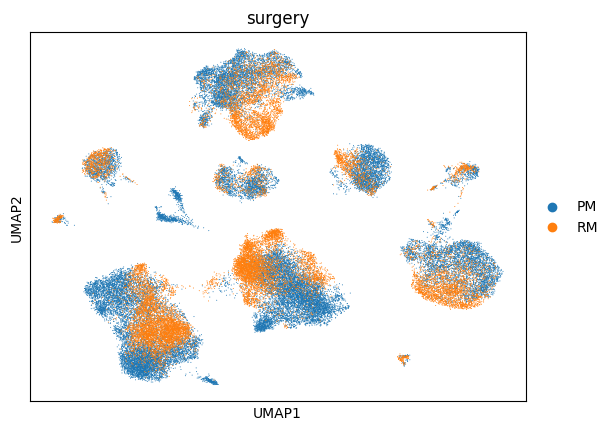

In [ ]:
sc.pp.neighbors(adata_hvg)
sc.tl.umap(adata_hvg)
sc.pl.umap(adata_hvg,color="surgery",size=2)

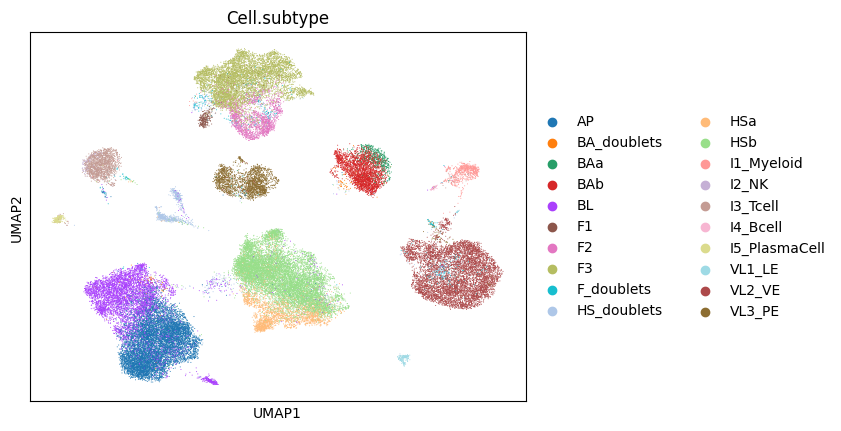

In [ ]:
sc.pl.umap(adata_hvg,color="Cell.subtype",size=2) 


In [ ]:

# Apply PCA
sc.pp.pca(adata_hvg)
# Run Harmony
sce.pp.harmony_integrate(adata_hvg, key='surgery', max_iter_harmony=50, theta=1.5)

print("check integration: ")
sc.pp.neighbors(adata_hvg, use_rep="X_pca_harmony")
sc.tl.umap(adata_hvg)
# Visualize UMAP
sc.pl.umap(adata_hvg, color=["sample","Cell.subtype" ])

In [ ]:
adata

AnnData object with n_obs × n_vars = 51473 × 20437
    obs: 'Major.subtype', 'Cell.subtype', 'Cell.subtype.postIEGregression', 'type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'surgery'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    layers: 'counts'

In [ ]:
#adata_hvg.write("breast_preprocessed_HV.h5ad")

In [4]:
adata_hvg = sc.read("breast_preprocessed_HV.h5ad")

NameError: name 'sc' is not defined

2025-02-18 18:48:51,120 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-02-18 18:48:54,352 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-02-18 18:48:54,522 - harmonypy - INFO - Iteration 1 of 50
2025-02-18 18:49:03,858 - harmonypy - INFO - Iteration 2 of 50
2025-02-18 18:49:13,368 - harmonypy - INFO - Iteration 3 of 50
2025-02-18 18:49:22,625 - harmonypy - INFO - Iteration 4 of 50
2025-02-18 18:49:27,997 - harmonypy - INFO - Iteration 5 of 50
2025-02-18 18:49:31,595 - harmonypy - INFO - Converged after 5 iterations


check integration: 


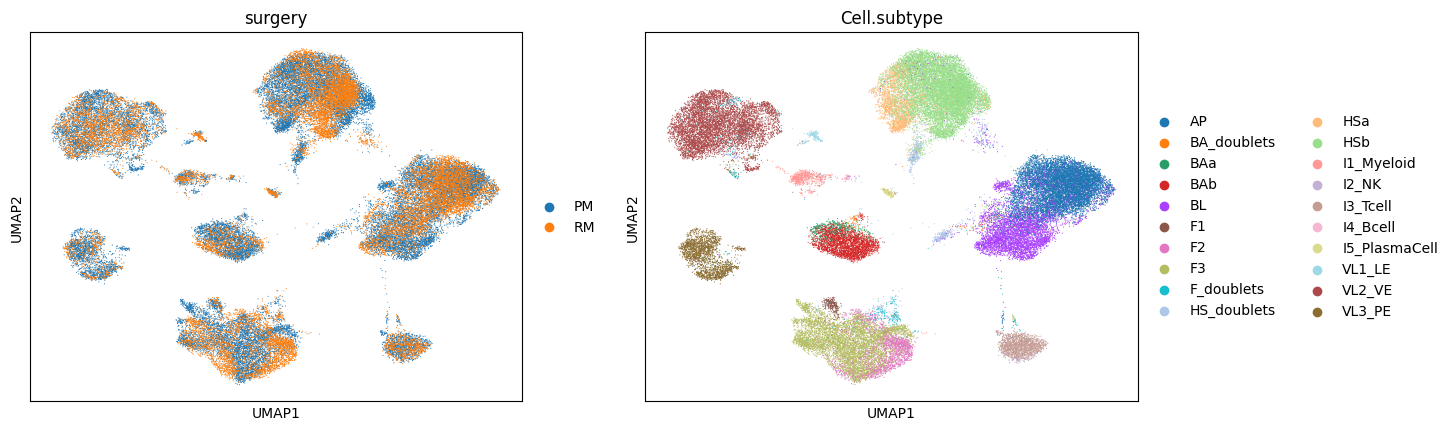

In [11]:

# Apply PCA
sc.pp.pca(adata_hvg)
# Run Harmony
sce.pp.harmony_integrate(adata_hvg, key='surgery', max_iter_harmony=50, theta=1.5)

print("check integration: ")
sc.pp.neighbors(adata_hvg, use_rep="X_pca_harmony")
sc.tl.umap(adata_hvg)
# Visualize UMAP
sc.pl.umap(adata_hvg, color=['surgery',"Cell.subtype" ])

In [17]:
cells_OOD =["I4_Bcell", "BAa", "I2_NK", "BA_doublets"] 
#cells_OOD = ["I4_Bcell"]

adata_hvg = adata_hvg[~adata_hvg.obs['Cell.subtype'].isin(cells_OOD)].copy()



In [18]:
adata_hvg.obs['surgery'].value_counts()

surgery
PM    31821
RM    18837
Name: count, dtype: int64

In [19]:
# Step 1: Select highly variable genes
#adata_hvg = adata[:, adata.var['highly_variable']]

# Step 2: Split datasets by 'surgery'
adata_ref = adata_hvg[adata_hvg.obs['surgery'] == 'RM']
adata_query = adata_hvg[adata_hvg.obs['surgery'] == 'PM']




In [20]:
adata_ref.var['gene_names'] = adata_ref.var_names
adata_query.var['gene_names'] = adata_query.var_names

/tmp/ipykernel_782488/3117212551.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_ref.var['gene_names'] = adata_ref.var_names
/tmp/ipykernel_782488/3117212551.py:2: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_query.var['gene_names'] = adata_query.var_names


In [21]:
adata_ref.write("breast_preprocessed_reference_2.h5ad")
adata_query.write("breast_preprocessed_query_2.h5ad")

In [28]:
#adata_ref.var['gene_names'] = adata_ref.var_names

In [29]:
#adata_ref.var['gene_names']


In [1]:
import scanpy as sc

In [6]:
adata_ref = sc.read("breast_preprocessed_reference_2.h5ad")
adata_query = sc.read("breast_preprocessed_query_2.h5ad")

In [7]:
adata_query

AnnData object with n_obs × n_vars = 31821 × 2000
    obs: 'Major.subtype', 'Cell.subtype', 'Cell.subtype.postIEGregression', 'type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'surgery'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'gene_names'
    uns: 'Cell.subtype_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'surgery_colors', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [8]:
adata_query.obs['Cell.subtype'].value_counts()

Cell.subtype
HSb              5715
AP               5074
F3               4555
BL               4046
VL2_VE           3963
HSa              1985
BAb              1880
VL3_PE           1610
I3_Tcell          987
HS_doublets       963
I1_Myeloid        381
F_doublets        228
F1                206
F2                 77
I5_PlasmaCell      77
VL1_LE             74
Name: count, dtype: int64

In [6]:
import scanpy as sc
import pandas as pd

# Load Experiment 1 datasets
adata_ref1 = sc.read_h5ad("breast_preprocessed_reference_1.h5ad")
adata_query1 = sc.read_h5ad("breast_preprocessed_query_1.h5ad")

# Load Experiment 2 datasets
adata_ref2 = sc.read_h5ad("breast_preprocessed_reference_2.h5ad")
adata_query2 = sc.read_h5ad("breast_preprocessed_query_2.h5ad")

# Get cell type counts for each split
counts_ref1 = adata_ref1.obs["Cell.subtype"].value_counts()
counts_query1 = adata_query1.obs["Cell.subtype"].value_counts()
counts_ref2 = adata_ref2.obs["Cell.subtype"].value_counts()
counts_query2 = adata_query2.obs["Cell.subtype"].value_counts()

# Create a union of all cell types observed across splits
cell_types = set(counts_ref1.index).union(counts_query1.index, counts_ref2.index, counts_query2.index)

# Build a DataFrame summarizing the counts
data = []
for ct in sorted(cell_types):
    ref1 = counts_ref1.get(ct, 0)
    query1 = counts_query1.get(ct, 0)
    ref2 = counts_ref2.get(ct, 0)
    query2 = counts_query2.get(ct, 0)
    data.append({
        'Cell Type': ct,
        'Exp1 Ref': ref1,
        'Exp1 Query': query1,
        'Exp2 Ref': ref2,
        'Exp2 Query': query2
    })
df = pd.DataFrame(data)

# Calculate totals for each split
totals = {
    'Exp1 Ref': df['Exp1 Ref'].sum(),
    'Exp1 Query': df['Exp1 Query'].sum(),
    'Exp2 Ref': df['Exp2 Ref'].sum(),
    'Exp2 Query': df['Exp2 Query'].sum()
}

# Loop over rows and print formatted LaTeX table rows with percentages
for idx, row in df.iterrows():
    exp1_ref_perc = row['Exp1 Ref'] / totals['Exp1 Ref'] * 100
    exp1_query_perc = row['Exp1 Query'] / totals['Exp1 Query'] * 100
    exp2_ref_perc = row['Exp2 Ref'] / totals['Exp2 Ref'] * 100
    exp2_query_perc = row['Exp2 Query'] / totals['Exp2 Query'] * 100
    print(f"{row['Cell Type']} & {row['Exp1 Ref']} ({exp1_ref_perc:.1f}\\%) & "
          f"{row['Exp1 Query']} ({exp1_query_perc:.1f}\\%) & {row['Exp2 Ref']} ({exp2_ref_perc:.1f}\\%) & "
          f"{row['Exp2 Query']} ({exp2_query_perc:.1f}\\%) \\\\")

# Print totals row (without percentages)
print(f"\\textbf{{Total}} & {totals['Exp1 Ref']} & {totals['Exp1 Query']} & {totals['Exp2 Ref']} & {totals['Exp2 Query']} \\\\")


AP & 5074 (15.6\%) & 3799 (20.1\%) & 3799 (20.2\%) & 5074 (15.9\%) \\
BA_doublets & 82 (0.3\%) & 33 (0.2\%) & 0 (0.0\%) & 0 (0.0\%) \\
BAa & 488 (1.5\%) & 27 (0.1\%) & 0 (0.0\%) & 0 (0.0\%) \\
BAb & 1880 (5.8\%) & 740 (3.9\%) & 740 (3.9\%) & 1880 (5.9\%) \\
BL & 4046 (12.5\%) & 1603 (8.5\%) & 1603 (8.5\%) & 4046 (12.7\%) \\
F1 & 206 (0.6\%) & 63 (0.3\%) & 63 (0.3\%) & 206 (0.6\%) \\
F2 & 77 (0.2\%) & 1627 (8.6\%) & 1627 (8.6\%) & 77 (0.2\%) \\
F3 & 4555 (14.0\%) & 1491 (7.9\%) & 1491 (7.9\%) & 4555 (14.3\%) \\
F_doublets & 228 (0.7\%) & 215 (1.1\%) & 215 (1.1\%) & 228 (0.7\%) \\
HS_doublets & 963 (3.0\%) & 230 (1.2\%) & 230 (1.2\%) & 963 (3.0\%) \\
HSa & 1985 (6.1\%) & 437 (2.3\%) & 437 (2.3\%) & 1985 (6.2\%) \\
HSb & 5715 (17.6\%) & 4639 (24.5\%) & 4639 (24.6\%) & 5715 (18.0\%) \\
I1_Myeloid & 381 (1.2\%) & 278 (1.5\%) & 278 (1.5\%) & 381 (1.2\%) \\
I2_NK & 76 (0.2\%) & 44 (0.2\%) & 0 (0.0\%) & 0 (0.0\%) \\
I3_Tcell & 987 (3.0\%) & 624 (3.3\%) & 624 (3.3\%) & 987 (3.1\%) \\
I5_PlasmaC